In [14]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score

import statsmodels.api as sm

In [15]:
pd.set_option("display.max_rows",50)
df=pd.read_csv('Phishing_Legitimate_full.csv')

#koniecznie usuwamy id bo przypisuje do tej kolumny predykcje, anstenie model ma metryki 1
df.drop(['id'],axis=1,inplace=True)

In [16]:
#podział zmiennych w modelu na numeryczne i kateogryczne 
target = 'CLASS_LABEL'
numFeatures = ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars','HostnameLength', 'PathLength', 'QueryLength',
       'NumSensitiveWords']
catFeatures = ['AtSymbol','TildeSymbol','NumHash', 'NoHttps','RandomString', 'IpAddress','DomainInSubdomains','DomainInPaths','HttpsInHostname',
              'DoubleSlashInPath','EmbeddedBrandName','PctExtHyperlinks','PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm','ExtMetaScriptLinkRT','UrlLengthRT','SubdomainLevelRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'PctExtNullSelfRedirectHyperlinksRT']

In [17]:
#one hot encoding (na wszelki wypadek)
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)

In [18]:
#standaryzacja zmiennych numerycznych
df[numFeatures] = df[numFeatures].apply(lambda x: (x-x.mean())/x.std())

In [19]:
features = df.columns.tolist()
features.remove(target)
print(features)

['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumNumericChars', 'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords', 'AtSymbol', 'TildeSymbol', 'NumHash', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'DoubleSlashInPath', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'ExtMetaScriptLinkRT', 'UrlLengthRT', 'SubdomainLevelRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'PctExtNullSelfRedirectHyperlinksRT']


In [20]:
#wrapper walidacji krzyżowej dla algorytmu kNN
def CVTestKNN(features=features, nFolds = 5, randomState=2020, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [21]:
#szukanie optymalnej ilości sąsiadów (n_neighbors)
for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    trainResults, testResults, predictions, indices = CVTestKNN(features=features, n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(trainResults), np.mean(testResults))
#dla 10 najlepszy

1 1.0 0.9507553213742799
3 0.9978007682435646 0.9767826602718259
5 0.9961163902205197 0.9815067599468292
10 0.9930096507097075 0.9847403423108823
15 0.9906246068209625 0.9847133457371748
30 0.9862995198556211 0.9826357403866455
50 0.9822578751844459 0.9797167281048587
100 0.9763079150456063 0.9747941738762028
150 0.9720846753391064 0.9710666221393085
200 0.9692732734828009 0.9684093972462877


In [22]:
# n_neighbors okolice 10 dla euclidean distance (p=2)
for k in [1,2,4,6,8,10,12,14,15]:
    trainResults, testResults, predictions, indices = CVTestKNN(features=features ,n_neighbors=k, n_jobs=-1, p=2)
    print(k, np.mean(testResults))

1 0.9507553213742799
2 0.9710560143525946
4 0.9802142065562224
6 0.9834660308438096
8 0.9846741790028153
10 0.9847403423108823
12 0.9849371160346125
14 0.9848923317512585
15 0.9847133457371748


In [23]:
#dla manhattan distance (okolice 10)
for k in [1,2,4,6,8,10,12,14,15]:
    trainResults, testResults, predictions, indices = CVTestKNN(features=features, n_neighbors=k, n_jobs=-1, p=1)
    print(k, np.mean(testResults))
# manhattan n_neighbors = 14 jest najlepszym modelem z użyciem algorytmu kNN

1 0.9560908286748873
2 0.9753835559422892
4 0.9835587166867036
6 0.986617659930397
8 0.9878820166376391
10 0.9886602297442071
12 0.9888285212858289
14 0.9891237795279576
15 0.9890448789084327


In [27]:
#sprawdzamy ważność dla poszczególnych zmiennych
results = []
for feature in features:
    trainResults, testResults, predictions, indices = CVTestKNN(features=[feature],n_neighbors=14, n_jobs=-1, p=1)
    print(feature, np.mean(testResults))
    results.append((feature, np.mean(testResults)))

NumDots 0.49883536814383983
SubdomainLevel 0.49889374120127006
PathLevel 0.5111136678365894
UrlLength 0.5644027220984836
NumDash 0.6128685610304062
NumDashInHostname 0.4982286623583592
NumUnderscore 0.5065626886318989
NumPercent 0.507676056895497
NumQueryComponents 0.5081126537741862
NumAmpersand 0.5055432766892008
NumNumericChars 0.4863021519105957
HostnameLength 0.490400360173596
PathLength 0.5707377429524497
QueryLength 0.5948587569787392
NumSensitiveWords 0.4996910401647786
AtSymbol 0.5003048660496686
TildeSymbol 0.5
NumHash 0.5
NoHttps 0.5
RandomString 0.5
IpAddress 0.5
DomainInSubdomains 0.5
DomainInPaths 0.5
HttpsInHostname 0.5
DoubleSlashInPath 0.4993103792104508
EmbeddedBrandName 0.5
PctExtHyperlinks 0.9329689572269741
PctExtResourceUrls 0.8257325293130741
ExtFavicon 0.5
InsecureForms 0.5
RelativeFormAction 0.5
ExtFormAction 0.5
AbnormalFormAction 0.5
PctNullSelfRedirectHyperlinks 0.7391806570707388
FrequentDomainNameMismatch 0.5
FakeLinkInStatusBar 0.5
RightClickDisabled 0.5


In [28]:
#sortujemy aby uzyskać najistotniejsze zmienne
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('PctExtHyperlinks', 0.9329689572269741),
 ('PctExtResourceUrls', 0.8257325293130741),
 ('PctNullSelfRedirectHyperlinks', 0.7391806570707388),
 ('NumDash', 0.6128685610304062),
 ('QueryLength', 0.5948587569787392),
 ('PathLength', 0.5707377429524497),
 ('UrlLength', 0.5644027220984836),
 ('PathLevel', 0.5111136678365894),
 ('NumQueryComponents', 0.5081126537741862),
 ('NumPercent', 0.507676056895497),
 ('NumUnderscore', 0.5065626886318989),
 ('NumAmpersand', 0.5055432766892008),
 ('PopUpWindow', 0.5046856429516745),
 ('AtSymbol', 0.5003048660496686),
 ('TildeSymbol', 0.5),
 ('NumHash', 0.5),
 ('NoHttps', 0.5),
 ('RandomString', 0.5),
 ('IpAddress', 0.5),
 ('DomainInSubdomains', 0.5),
 ('DomainInPaths', 0.5),
 ('HttpsInHostname', 0.5),
 ('EmbeddedBrandName', 0.5),
 ('ExtFavicon', 0.5),
 ('InsecureForms', 0.5),
 ('RelativeFormAction', 0.5),
 ('ExtFormAction', 0.5),
 ('AbnormalFormAction', 0.5),
 ('FrequentDomainNameMismatch', 0.5),
 ('FakeLinkInStatusBar', 0.5),
 ('RightClickDisabled', 

In [34]:
#usuwamy zmienne, których ważność jest mniejsza od 0.5
featuresSet2 = [x for x,y in results if y >= 0.5]
print(featuresSet2)

['PctExtHyperlinks', 'PctExtResourceUrls', 'PctNullSelfRedirectHyperlinks', 'NumDash', 'QueryLength', 'PathLength', 'UrlLength', 'PathLevel', 'NumQueryComponents', 'NumPercent', 'NumUnderscore', 'NumAmpersand', 'PopUpWindow', 'AtSymbol', 'TildeSymbol', 'NumHash', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'EmbeddedBrandName', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'ExtMetaScriptLinkRT', 'UrlLengthRT', 'SubdomainLevelRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'PctExtNullSelfRedirectHyperlinksRT']


In [30]:
trainResults, testResults, predictions, indices = CVTestKNN(features=featuresSet2,n_neighbors=14, n_jobs=-1, p=1)
print(np.mean(testResults))
#gorzej bo wcześniej 0,988

0.9833493767521986


In [31]:
#usuwamy mniejszą część zmiennych niż poprzednio i patrzymy na wynik
featuresSet3 = [x for x,y in results if y >= 0.495]
trainResults, testResults, predictions, indices = CVTestKNN(features=featuresSet3,n_neighbors=14, n_jobs=-1, p=1)
print(np.mean(testResults))
#blisko ale nadal gorzej

0.9876242469645911


In [32]:
#tym razem usuwamy jeszcze mniej zmiennych
featuresSet4 = [x for x,y in results if y >= 0.49]
trainResults, testResults, predictions, indices = CVTestKNN(features=featuresSet4,n_neighbors=14, n_jobs=-1, p=1)
print(np.mean(testResults))
#tez gorzej, nie usuwamy zmiennych

0.9871259343157984


In [33]:
#teraz dokonamy feature generation w postaci rozszerzania lub zawężania rozpiętości
dfCopy = df.copy()
results2 = []
for feature in features:
    df = dfCopy.copy()
    df[feature]=df[feature]*2
    trainResults, testResults, predictions, indices = CVTestKNN(features=features,n_neighbors=14, n_jobs=-1, p=1)
    print(feature, np.mean(testResults))
    results2.append((feature, np.mean(testResults)))

NumDots 0.9888675684420086
SubdomainLevel 0.988988769913813
PathLevel 0.9887944308406178
UrlLength 0.9887051474294429
NumDash 0.9890289036162325
NumDashInHostname 0.9889855827998071
NumUnderscore 0.9890999359756577
NumPercent 0.9890086908723464
NumQueryComponents 0.9889448055928938
NumAmpersand 0.9889104021117546
NumNumericChars 0.9888757623369007
HostnameLength 0.988310392138086
PathLength 0.9890820883897238
QueryLength 0.9887268094107806
NumSensitiveWords 0.9891985773811205
AtSymbol 0.9891249795502578
TildeSymbol 0.9890849423303318
NumHash 0.9891399801111784
NoHttps 0.9891309784978363
RandomString 0.9882057663904064
IpAddress 0.9890968939827754
DomainInSubdomains 0.9891170749344014
DomainInPaths 0.9886459515246144
HttpsInHostname 0.9891237795279576
DoubleSlashInPath 0.989128079664761
EmbeddedBrandName 0.9892607179906328
PctExtHyperlinks 0.9892606768709914
PctExtResourceUrls 0.9890132997636073
ExtFavicon 0.9892906578829157
InsecureForms 0.9892645984995042
RelativeFormAction 0.98899610

In [35]:
#najistotniejsze zmienne
results2 = sorted(results2, key=lambda x: x[1], reverse=True)
results2

[('SubmitInfoToEmail', 0.989620225887986),
 ('ImagesOnlyInForm', 0.9892952747196186),
 ('ExtFavicon', 0.9892906578829157),
 ('InsecureForms', 0.9892645984995042),
 ('EmbeddedBrandName', 0.9892607179906328),
 ('PctExtHyperlinks', 0.9892606768709914),
 ('NumSensitiveWords', 0.9891985773811205),
 ('MissingTitle', 0.9891774984599422),
 ('PctNullSelfRedirectHyperlinks', 0.9891473593828797),
 ('NumHash', 0.9891399801111784),
 ('NoHttps', 0.9891309784978363),
 ('SubdomainLevelRT', 0.9891280797540356),
 ('DoubleSlashInPath', 0.989128079664761),
 ('AtSymbol', 0.9891249795502578),
 ('PopUpWindow', 0.9891238835983135),
 ('HttpsInHostname', 0.9891237795279576),
 ('DomainInSubdomains', 0.9891170749344014),
 ('FakeLinkInStatusBar', 0.9891161758279413),
 ('RightClickDisabled', 0.9891011637117751),
 ('NumUnderscore', 0.9890999359756577),
 ('IpAddress', 0.9890968939827754),
 ('FrequentDomainNameMismatch', 0.9890875734149258),
 ('TildeSymbol', 0.9890849423303318),
 ('PathLength', 0.9890820883897238),
 (

In [36]:
#zobaczymy zwiększenie rozpiętości najważniejszej zmiennej  
for k in [1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    df["SubmitInfoToEmail"]=df["SubmitInfoToEmail"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(features=features, n_neighbors=14, n_jobs=-1, p=1)
    print(k, np.mean(testResults))
# dla 3 najlepsze 

1.5 0.9894262081967284
2 0.989620225887986
3 0.989723796256506
4 0.9897839253629683
5 0.9895835167777529


In [38]:
# zwiększenie rozpiętości dla 2 najważniejszej zmiennej
for k in [1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    df["SubmitInfoToEmail"]=df["SubmitInfoToEmail"]*4
    df["ImagesOnlyInForm"]=df["ImagesOnlyInForm"]*4
    trainResults, testResults, predictions, indices = CVTestKNN(features=features, n_neighbors=14, n_jobs=-1, p=1)
    print(k, np.mean(testResults))
# ImagesOnlyInForm = 4

1.5 0.9898105664942808
2 0.989875797675371
3 0.9898703752769897
4 0.9898938139869145
5 0.9898675925012468


In [39]:
# zwiększenie rozpiętości dla kolejnej zmiennej
for k in [1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    # k krotnie zwiększamy zmienną
    df["SubmitInfoToEmail"]=df["SubmitInfoToEmail"]*4
    df["ExtFavicon"]=df["ExtFavicon"]*k
    df["ImagesOnlyInForm"]=df["ImagesOnlyInForm"]*4
    trainResults, testResults, predictions, indices = CVTestKNN(features=features, n_neighbors=14, n_jobs=-1, p=1)
    print(k, np.mean(testResults))
#ExtFavicon= 2 i przy tym bym został

1.5 0.989904124476287
2 0.9899438701372043
3 0.989801243849471
4 0.9898308900972822
5 0.9897812964941466


In [41]:
#zawężenie rozpiętości dla najmniej istotnej zmiennej
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8]:
    df = dfCopy.copy()
    
    df["SubmitInfoToEmail"]=df["SubmitInfoToEmail"]*4
    df["ExtFavicon"]=df["ExtFavicon"]*k
    df["ImagesOnlyInForm"]=df["ImagesOnlyInForm"]*4
    df["ExtMetaScriptLinkRT"]=df["ExtMetaScriptLinkRT"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(features=features,n_neighbors=14, n_jobs=-1, p=1)
    print(k, np.mean(testResults))

0.1 0.9881517971330087
0.25 0.9888241788554314
0.4 0.989497036939258
0.5 0.9897387928068937
0.65 0.9899425402843212
0.8 0.9901138126677427


In [42]:
df = dfCopy.copy()
df["SubmitInfoToEmail"]=df["SubmitInfoToEmail"]*4
df["InsecureForms"]=df["InsecureForms"]*2
df["ImagesOnlyInForm"]=df["ImagesOnlyInForm"]*4
df["ExtMetaScriptLinkRT"]=df["ExtMetaScriptLinkRT"]*0.8
trainResults, testResults, predictions, indices = CVTestKNN(features=features,n_neighbors=14, n_jobs=-1, p=1)
print(np.mean(testResults))

modelkNN = {
    "name":"KNN",
    "description":"Pierwszy dopracowany model KNN, 14 sąsiadów z wszystkimi zmiennymi",
    "specification":'n_neighbors=30, n_jobs=-1, p=1, features=features',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}
#trenujemy i zapisujemy najlepszy otrzymany model kNN

0.9906375958030411


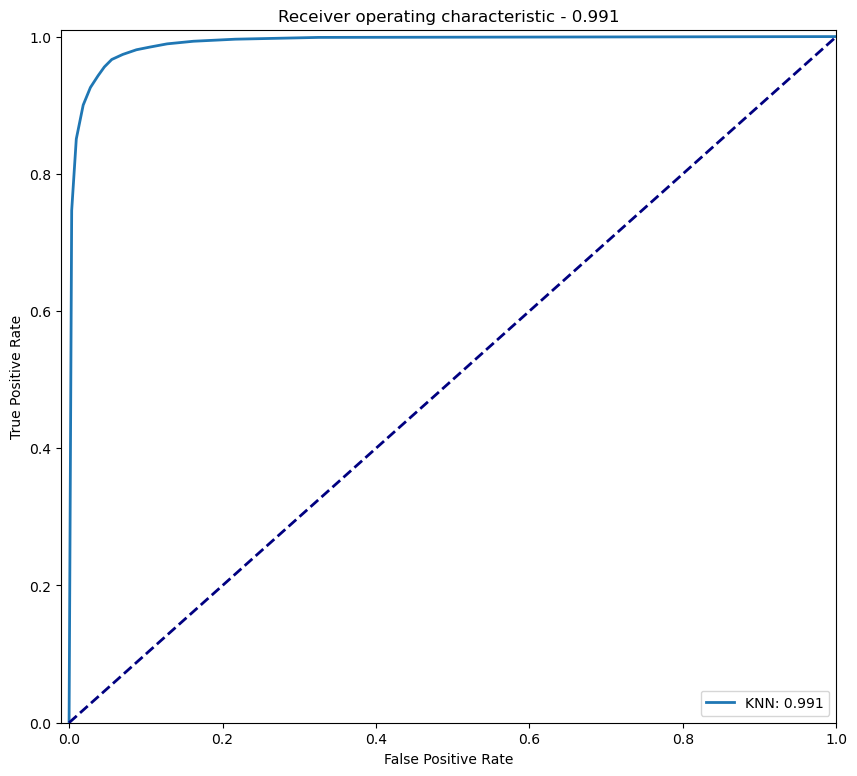

In [43]:
def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''

    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))

    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

res2plot = []
true = (df[target]==1).sort_index()
pred = pd.Series(sum(modelkNN["predictions"], []), index=sum(modelkNN["indices"], [])).sort_index()
res2plot.append((true, pred, modelkNN["name"]))

plotROCs(res2plot)